In [1]:
import pandas as pd
import numpy as np
import wrangle
import explore

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from math import sqrt

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE

## Wrangle My Data:
- Acquire my dataframe
- Prepare/Clean my dataframe
- Address outliers
- Complete initial exploration to verify.

In [2]:
# acquire my dataframe from sql
df = wrangle.get_zillow()

In [3]:
# use my info function to find out more information
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38396 entries, 0 to 38395
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    38396 non-null  float64
 1   bathroomcnt                   38396 non-null  float64
 2   calculatedfinishedsquarefeet  38288 non-null  float64
 3   taxvaluedollarcnt             38395 non-null  float64
 4   yearbuilt                     38264 non-null  float64
 5   taxamount                     38395 non-null  float64
 6   fips                          38396 non-null  float64
 7   parcelid                      38396 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 2.3 MB
None
------------------------
------------------------
This dataframe has 38396 rows and 8 columns.
------------------------
Null count in dataframe:
------------------------
bedroomcnt                        0
bathroomcnt                       0
calcu

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid
19460,5.0,3.0,2631.0,944325.0,1996.0,10783.54,6059.0,14289934
22957,3.0,2.0,1696.0,364415.0,1950.0,4475.20,6037.0,10819752
34336,3.0,1.0,1090.0,137931.0,1946.0,2692.97,6037.0,12286411


In [4]:
# let's put the data we just obtained 
df = wrangle.clean_zillow(df)

num_bedroom      0
num_bathroom     0
finished_sqft    0
tax_value        0
build_year       0
property_tax     0
fips             0
parcelid         0
dtype: int64
This dataframe has 38258 rows and 8 columns.


In [5]:
# see what's changed on my clean data
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38226 entries, 0 to 38395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_bedroom    38226 non-null  float64
 1   num_bathroom   38226 non-null  float64
 2   finished_sqft  38226 non-null  float64
 3   tax_value      38226 non-null  float64
 4   build_year     38226 non-null  float64
 5   property_tax   38226 non-null  float64
 6   fips           38226 non-null  float64
 7   state          38226 non-null  object 
 8   county         38226 non-null  object 
 9   tax_rate       38226 non-null  float64
dtypes: float64(8), object(2)
memory usage: 3.2+ MB
None
------------------------
------------------------
This dataframe has 38226 rows and 10 columns.
------------------------
Null count in dataframe:
------------------------
num_bedroom      0
num_bathroom     0
finished_sqft    0
tax_value        0
build_year       0
property_tax     0
fips             0
st

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,property_tax,fips,state,county,tax_rate
10957,4.0,2.0,1770.0,515156.0,1965.0,5160.90,6059.0,California,Orange,1.001813
3963,4.0,4.5,5130.0,2917860.0,1998.0,30971.92,6059.0,California,Orange,1.061460
34669,3.0,2.0,1582.0,232499.0,1964.0,3194.09,6037.0,California,Los Angeles,1.373808


In [6]:
# Tells us unique count
df.nunique()

num_bedroom         13
num_bathroom        19
finished_sqft     4187
tax_value        28238
build_year         131
property_tax     37317
fips                 3
state                1
county               3
tax_rate         38110
dtype: int64

In [7]:
column = ['num_bedroom', 'num_bathroom', 'fips']
wrangle.value_counts(df, column)

num_bedroom
3.0     15503
2.0      9685
4.0      8680
5.0      2151
1.0      1659
6.0       338
0.0       143
7.0        50
8.0         8
9.0         4
10.0        2
11.0        2
12.0        1
Name: num_bedroom, dtype: int64
-------------
num_bathroom
2.0     15827
3.0      8286
1.0      6555
2.5      3606
4.0      1336
1.5       736
3.5       594
5.0       456
4.5       385
6.0       179
5.5       111
7.0        52
0.0        30
8.0        29
6.5        27
7.5         9
9.0         5
11.0        2
10.0        1
Name: num_bathroom, dtype: int64
-------------
fips
6037.0    23989
6059.0    11068
6111.0     3169
Name: fips, dtype: int64
-------------


In [8]:
df.head()

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,property_tax,fips,state,county,tax_rate
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,California,Orange,1.205811
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,California,Los Angeles,1.280929
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,California,Los Angeles,1.704505
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,California,Los Angeles,1.160365
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,California,Los Angeles,1.526962


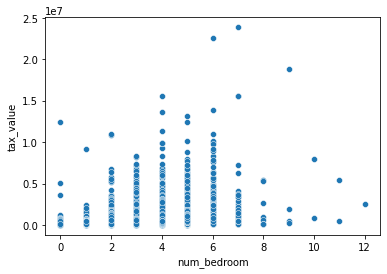

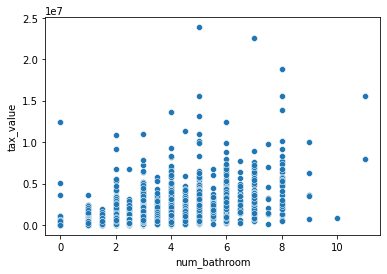

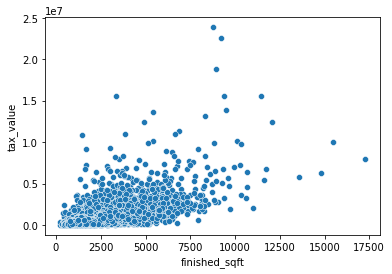

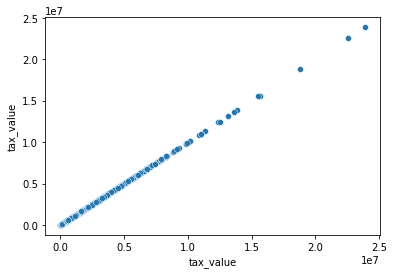

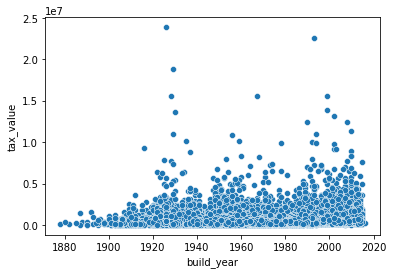

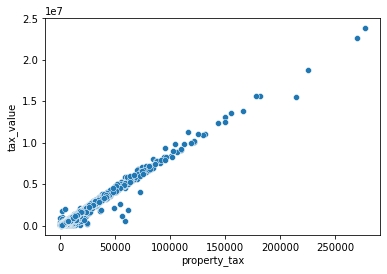

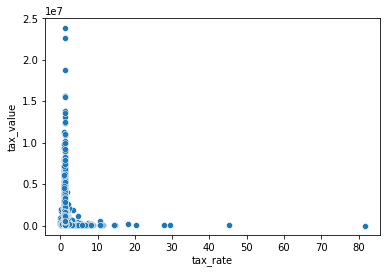

In [9]:
# visualize outliers of my numeric columns
cols = df.drop(columns=['fips', 'state', 'county'])
explore.scatterplot(cols, df.tax_value, df)

In [10]:
df.shape

(38226, 10)

In [11]:
df.head()

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,property_tax,fips,state,county,tax_rate
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,California,Orange,1.205811
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,California,Los Angeles,1.280929
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,California,Los Angeles,1.704505
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,California,Los Angeles,1.160365
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,California,Los Angeles,1.526962


In [12]:
# remove outliers
cols = df.drop(columns=['fips', 'state', 'county'])
df = wrangle.outlier_bounds(df, cols)
df.shape

For num_bedroom the lower bound is 0 and  upper bound is 7.0
For num_bathroom the lower bound is 0.5 and  upper bound is 4.5
For finished_sqft the lower bound is 0 and  upper bound is 3329.0
For tax_value the lower bound is 0 and  upper bound is 1031868.5
For build_year the lower bound is 1907.125 and  upper bound is 2016.0
For property_tax the lower bound is 0 and  upper bound is 11316.872500000001
For tax_rate the lower bound is 0.8926041934509568 and  upper bound is 1.6256905756483346


(30268, 10)

In [13]:
# take a look at the dataframe with removed outliers
df.head(3)

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,property_tax,fips,state,county,tax_rate
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,California,Orange,1.205811
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,California,Los Angeles,1.280929
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,California,Los Angeles,1.160365


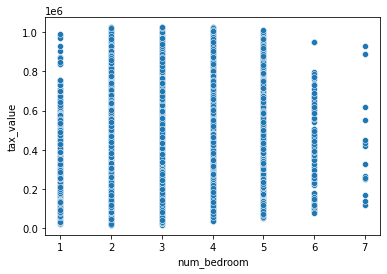

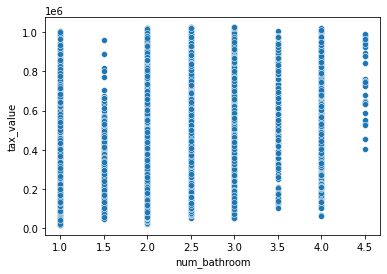

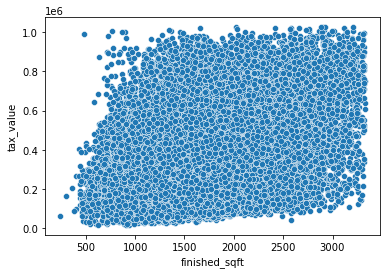

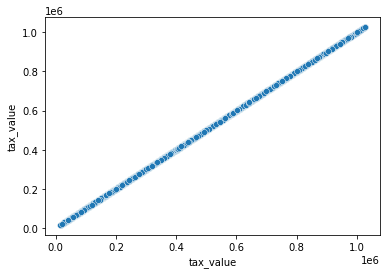

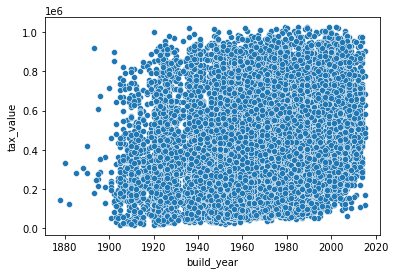

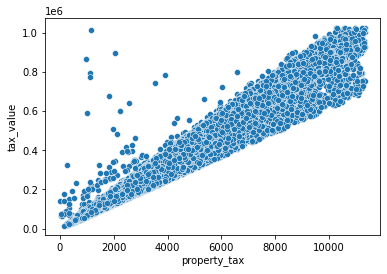

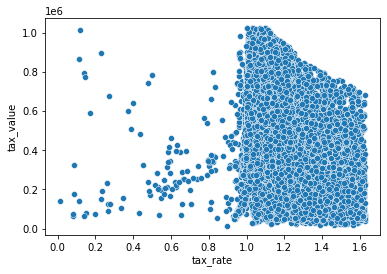

In [14]:
# visualize outliers of my numeric columns
cols = df.drop(columns=['fips', 'state', 'county'])
explore.scatterplot(cols, df.tax_value, df)

In [15]:
# take a look at clean value counts
column = ['num_bedroom', 'num_bathroom', 'fips']
wrangle.value_counts(df, column)

num_bedroom
3.0    12658
2.0     8617
4.0     6299
1.0     1540
5.0     1037
6.0      103
7.0       14
Name: num_bedroom, dtype: int64
-------------
num_bathroom
2.0    13618
3.0     6517
1.0     5437
2.5     3281
1.5      684
4.0      478
3.5      224
4.5       29
Name: num_bathroom, dtype: int64
-------------
fips
6037.0    18325
6059.0     9206
6111.0     2737
Name: fips, dtype: int64
-------------


### Acquire/Prepare Takeaways:
- I acquire my data.
- I cleaned thoroughly cleaned and prepared my data by:
 - replacing whitespaces with nans,
 - dropping any duplicates and nulls
 - renamed columns
 - created columns (tax_rate, county, state)
 - addressed and removed any outliers

In [16]:
# To use when I want to concatenate my dfs back together
# df = pd.concat([x_train_scaled, y_train], axis=0)